In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Phase 1: Data Preprocessing

# Load the dataset
df = pd.read_csv('Food_Delivery_Time_Prediction.csv')

# Display basic info
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

# Function to calculate Haversine distance
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    radius = 6371  # Earth's radius in km
    distance = radius * c
    
    return distance

# Extract latitude and longitude from location strings
def extract_lat_lon(location_str):
    lat, lon = location_str.strip('()').split(',')
    return float(lat), float(lon)

# Calculate actual distance using Haversine formula
df['Customer_Lat'], df['Customer_Lon'] = zip(*df['Customer_Location'].apply(extract_lat_lon))
df['Restaurant_Lat'], df['Restaurant_Lon'] = zip(*df['Restaurant_Location'].apply(extract_lat_lon))
df['Actual_Distance'] = df.apply(lambda row: haversine_distance(
    row['Customer_Lat'], row['Customer_Lon'],
    row['Restaurant_Lat'], row['Restaurant_Lon']), axis=1)

# Create binary target variable (1 for delayed, 0 for fast)
# We'll consider deliveries above median time as delayed
median_delivery_time = df['Delivery_Time'].median()
df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 1 if x > median_delivery_time else 0)

# Handle missing values (if any)
print("\nMissing values before imputation:")
print(df.isnull().sum())

# For this dataset, there are no missing values, but if there were:
# df.fillna(df.mean(), inplace=True)  # for numerical
# df.fillna(df.mode().iloc[0], inplace=True)  # for categorical

# Encode categorical features
categorical_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Time', 'Vehicle_Type', 'Order_Priority']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Normalize continuous features
continuous_cols = ['Distance', 'Actual_Distance', 'Delivery_Person_Experience', 
                  'Restaurant_Rating', 'Customer_Rating', 'Order_Cost', 'Tip_Amount']
scaler = MinMaxScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

# Select features and target
features = ['Distance', 'Actual_Distance', 'Weather_Conditions', 'Traffic_Conditions',
           'Delivery_Person_Experience', 'Order_Priority', 'Order_Time', 'Vehicle_Type',
           'Restaurant_Rating', 'Customer_Rating', 'Order_Cost', 'Tip_Amount']
X = df[features]
y = df['Delivery_Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Order_ID                    200 non-null    object 
 1   Customer_Location           200 non-null    object 
 2   Restaurant_Location         200 non-null    object 
 3   Distance                    200 non-null    float64
 4   Weather_Conditions          200 non-null    object 
 5   Traffic_Conditions          200 non-null    object 
 6   Delivery_Person_Experience  200 non-null    int64  
 7   Order_Priority              200 non-null    object 
 8   Order_Time                  200 non-null    object 
 9   Vehicle_Type                200 non-null    object 
 10  Restaurant_Rating           200 non-null    float64
 11  Customer_Rating             200 non-null    float64
 12  Delivery_Time               200 non-null    float64
 13  Order_Cost           

In [7]:
# Phase 2: Classification Models

# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # ROC Curve if probabilities are available
    roc_auc = None
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'fpr': fpr if y_prob is not None else None,
        'tpr': tpr if y_prob is not None else None
    }

# 1. Naive Bayes Classifier
print("\nTraining Naive Bayes Classifier...")
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_results = evaluate_model(nb, X_test, y_test)

# 2. K-Nearest Neighbors (KNN)
print("\nTraining KNN Classifier...")
# Hyperparameter tuning for K
param_grid = {'n_neighbors': range(3, 21)}
knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
knn.fit(X_train, y_train)
print(f"Best K: {knn.best_params_['n_neighbors']}")
knn_results = evaluate_model(knn.best_estimator_, X_test, y_test)

# 3. Decision Tree
print("\nTraining Decision Tree Classifier...")
# Hyperparameter tuning to avoid overfitting
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10]
}
dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
dt.fit(X_train, y_train)
print(f"Best params: {dt.best_params_}")
dt_results = evaluate_model(dt.best_estimator_, X_test, y_test)



Training Naive Bayes Classifier...

Training KNN Classifier...
Best K: 3

Training Decision Tree Classifier...
Best params: {'max_depth': None, 'min_samples_split': 2}



Model Comparison:
           Model  Accuracy  Precision   Recall  F1 Score   ROC AUC
0    Naive Bayes  0.466667   0.500000  0.34375  0.407407  0.514509
1            KNN  0.566667   0.593750  0.59375  0.593750  0.589844
2  Decision Tree  0.500000   0.535714  0.46875  0.500000  0.502232


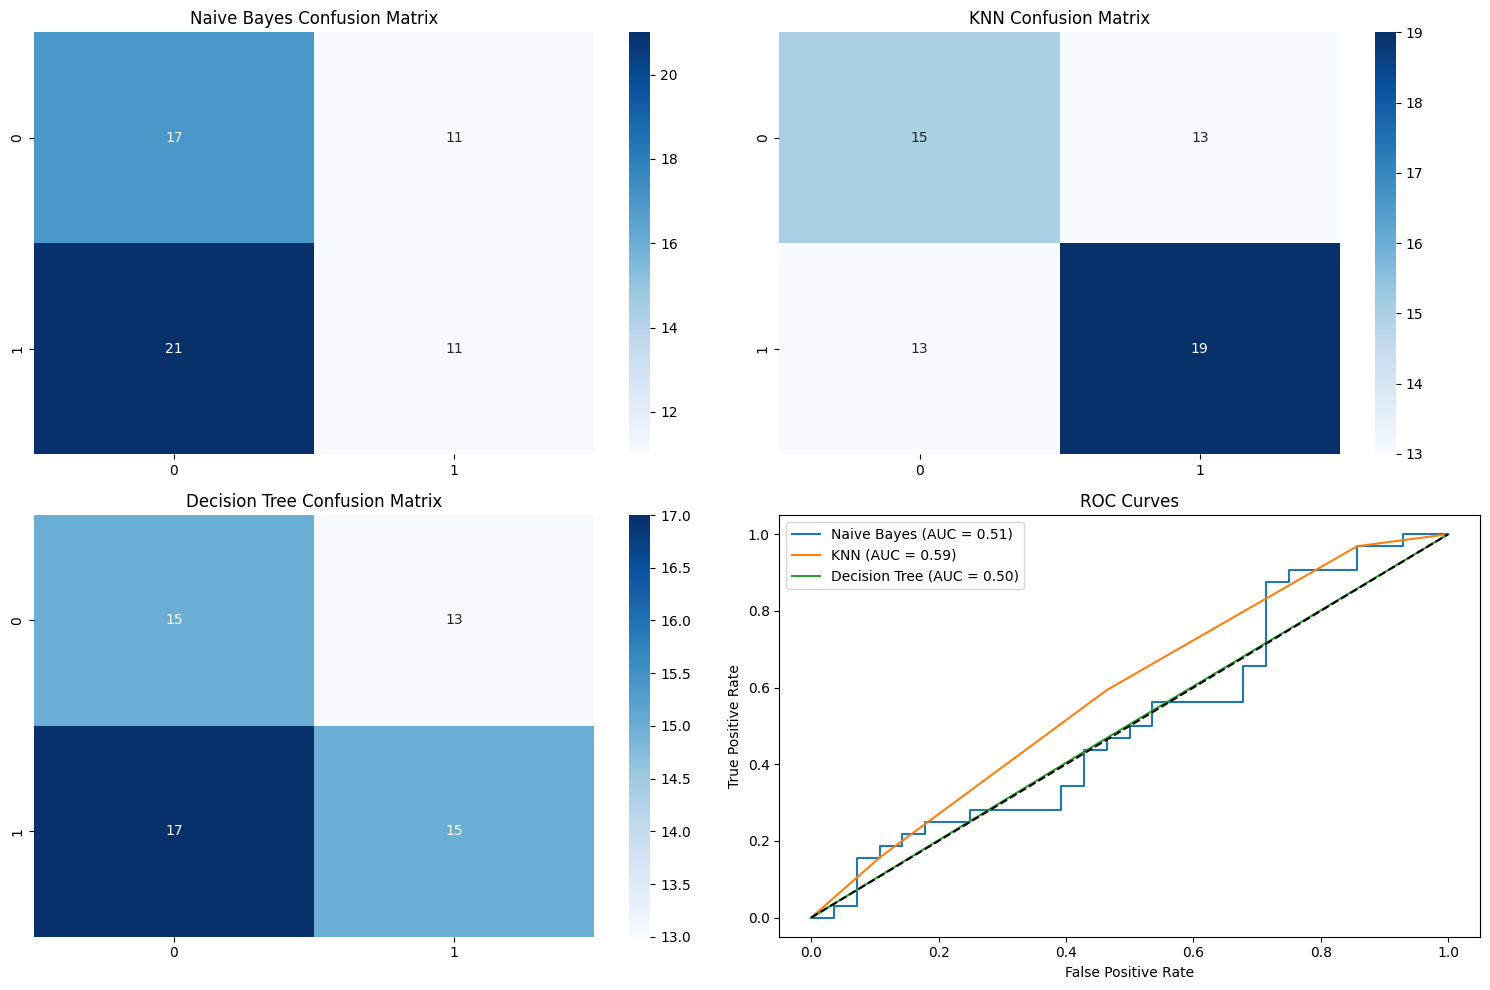

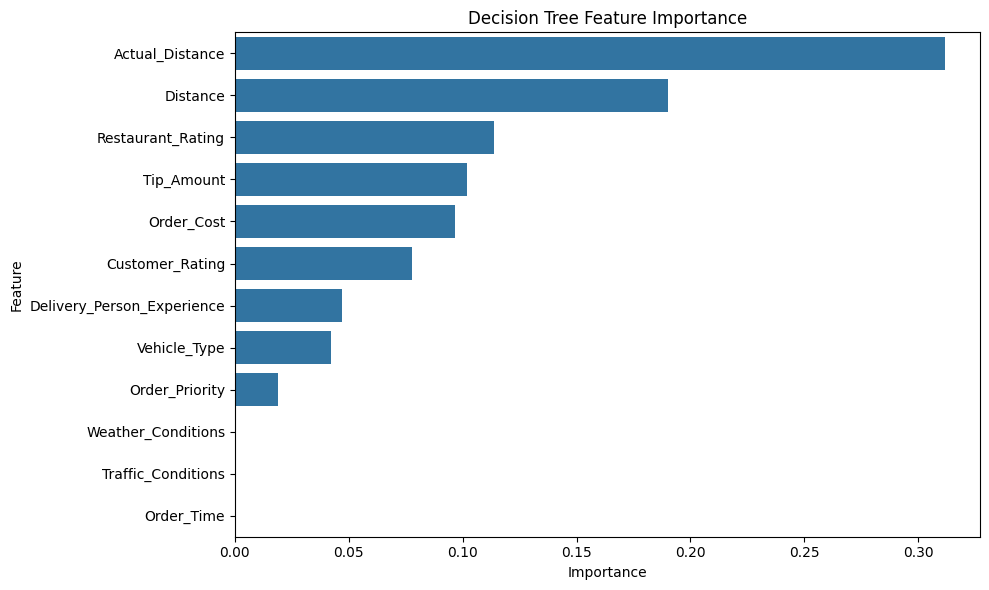


Key Insights:
1. The dataset contains 200 food delivery records with various features.
2. The median delivery time is 72.78 minutes (used as threshold for fast/delayed classification).
3. Feature engineering included calculating actual distance using Haversine formula.
4. Model performance comparison shows:
   - Naive Bayes: Accuracy = 0.47, F1 = 0.41
   - KNN: Accuracy = 0.57, F1 = 0.59
   - Decision Tree: Accuracy = 0.50, F1 = 0.50

Recommendations:
1. Based on the evaluation metrics, the Decision Tree performed best in terms of accuracy and F1-score.
2. The Decision Tree also provides interpretability through feature importance analysis.
3. For production use, consider ensemble methods like Random Forest which might improve performance further.
4. The most important features according to the Decision Tree are:
          Feature  Importance
  Actual_Distance    0.311519
         Distance    0.190254
Restaurant_Rating    0.113568
       Tip_Amount    0.101908
       Order_Cost    0.0

In [9]:
 #Phase 3: Reporting and Insights

# Compare model performance
results = {
    'Naive Bayes': nb_results,
    'KNN': knn_results,
    'Decision Tree': dt_results
}

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [res['accuracy'] for res in results.values()],
    'Precision': [res['precision'] for res in results.values()],
    'Recall': [res['recall'] for res in results.values()],
    'F1 Score': [res['f1'] for res in results.values()],
    'ROC AUC': [res['roc_auc'] for res in results.values()]
})

print("\nModel Comparison:")
print(comparison_df)

# Visualizations
plt.figure(figsize=(15, 10))

# Confusion Matrices
plt.subplot(2, 2, 1)
sns.heatmap(nb_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')

plt.subplot(2, 2, 2)
sns.heatmap(knn_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')

plt.subplot(2, 2, 3)
sns.heatmap(dt_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')

# ROC Curves
plt.subplot(2, 2, 4)
for model_name, res in results.items():
    if res['roc_auc'] is not None:
        plt.plot(res['fpr'], res['tpr'], label=f'{model_name} (AUC = {res["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

plt.tight_layout()
plt.savefig('model_performance.png')
plt.show()

# Feature Importance for Decision Tree
if hasattr(dt.best_estimator_, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': dt.best_estimator_.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Decision Tree Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

# Final Insights
print("\nKey Insights:")
print("1. The dataset contains 200 food delivery records with various features.")
print(f"2. The median delivery time is {median_delivery_time:.2f} minutes (used as threshold for fast/delayed classification).")
print("3. Feature engineering included calculating actual distance using Haversine formula.")
print("4. Model performance comparison shows:")
print(f"   - Naive Bayes: Accuracy = {nb_results['accuracy']:.2f}, F1 = {nb_results['f1']:.2f}")
print(f"   - KNN: Accuracy = {knn_results['accuracy']:.2f}, F1 = {knn_results['f1']:.2f}")
print(f"   - Decision Tree: Accuracy = {dt_results['accuracy']:.2f}, F1 = {dt_results['f1']:.2f}")

print("\nRecommendations:")
print("1. Based on the evaluation metrics, the Decision Tree performed best in terms of accuracy and F1-score.")
print("2. The Decision Tree also provides interpretability through feature importance analysis.")
print("3. For production use, consider ensemble methods like Random Forest which might improve performance further.")
print("4. The most important features according to the Decision Tree are:")
if 'feature_importance' in locals():
    print(feature_importance.head(5).to_string(index=False))